<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Технологический-процесс" data-toc-modified-id="Технологический-процесс-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Технологический процесс</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды
Сборный проект 2
Выполнил Максим Ларин

## Цель:

Подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной
работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды используя данные с
параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Технологический процесс

<br>
<img src="https://pictures.s3.yandex.net/resources/viruchka_1576238830.jpg" width="1000" height="600">

<br><br>Расчёт эффективности
<img src='https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg' width="1000" height="200">

C — доля золота в концентрате после флотации/очистки;
F — доля золота в сырье/концентрате до флотации/очистки;
T — доля золота в отвальных хвостах после флотации/очистки.

<br><br>Метрика качества
<img src='https://pictures.s3.yandex.net/resources/smape_1576239058.jpg' width="1000" height="200">

sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»)
Одинаково учитывает масштаб и целевого признака, и предсказания.
<br><br>
<img src='https://pictures.s3.yandex.net/resources/_smape_1576239054.jpg' width="1000" height="200">

Нужно спрогнозировать сразу две величины:
эффективность обогащения чернового концентрата rougher.output.recovery;
эффективность обогащения финального концентрата final.output.recovery.


## Описание данных
***Технологический процесс***

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    > Xanthate **— ксантогенат (промотер, или активатор флотации);<br>
    >  Sulphate — сульфат (на данном производстве сульфид натрия);<br>
    > Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

***Параметры этапов***
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

***Наименование признаков***
Наименование признаков должно быть такое:<br>
 > `[этап].[тип_параметра].[название_параметра]`<br>
 > ``Пример: rougher.input.feed_ag``<br>
 > ```Возможные значения для блока [этап]:```<br>
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики
- Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.
1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
1.4. Проведите предобработку данных.
2. Проанализируйте данные
2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.
2.2.  Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.
2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.
3. Постройте модель
3.1. Напишите функцию для вычисления итоговой sMAPE.
3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.



## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from scipy import stats as st
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as ex
from plotly.subplots import make_subplots

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.dummy import DummyClassifier


In [3]:
try:
    from pandas_profiling import ProfileReport
except:
    !pip3 install pandas-profiling == 3.6.3
    from pandas_profiling import ProfileReport


In [4]:
try:
    data_train = pd.read_csv('gold_recovery_train_new.csv', index_col='date')
    data_test = pd.read_csv('gold_recovery_test_new.csv', index_col='date')
    data_full = pd.read_csv('gold_recovery_full_new.csv', index_col='date')
except:
    data_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv', index_col='date')
    data_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv', index_col='date')
    data_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv', index_col='date')


In [5]:
print('data_test')
display(data_test.info())
print()
print('data_train')
display( data_train.info())
print()
print('data_full')
display( data_full.info())
print()

data_test
<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    529

None


data_train
<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                 

None


data_full
<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                  

None

Видим, что в data_test на 34 столбца меньше чем в остальных <br>
Во всех столбцах тип данных числовой и есть пропуски <br>

In [6]:
# посмотрим на данные
display(f'data_test', data_test.head(5))
display(f'data_train', data_train.head(5))
display(f'data_full', data_full.head(5))

'data_test'

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


'data_train'

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


'data_full'

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691



Проверим названия столбзов данных trein и full равны или нет


In [7]:
# проверим названия столбзов данных trein и full равны или нет
if np.array_equal(data_full.columns, data_train.columns):
    print('Названия столбцов data_full и data_trein совпадают')
# проверим на дубликаты
for i, ii in zip([data_test, data_train, data_full], ['data_test', 'data_train', 'data_full']):
    s = i.duplicated().sum()
    print(f'Количество дубликатов в данных {ii} равно {s}')

Названия столбцов data_full и data_trein совпадают
Количество дубликатов в данных data_test равно 0
Количество дубликатов в данных data_train равно 0
Количество дубликатов в данных data_full равно 0


In [8]:
display('data_test', data_test.describe(include='all'))
display('data_train', data_train.describe(include='all'))
display('data_full', data_full.describe(include='all'))

'data_test'

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


'data_train'

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


'data_full'

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


Видим, что train и full выборки равны по количеству и названию столбцов<br>
В data_full есть пропуски<br>
Test и train выборки отличаются по количеству признаков, что является препятствием, для проверки модели<br>
Посмотрим каких столбцов нехватает в test данных?

In [9]:
gone_columns = list(set(data_train.columns) - set(data_test.columns))
gone_columns

['rougher.output.tail_au',
 'final.output.tail_ag',
 'final.output.concentrate_ag',
 'secondary_cleaner.output.tail_sol',
 'final.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'secondary_cleaner.output.tail_ag',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'final.output.concentrate_sol',
 'primary_cleaner.output.tail_pb',
 'rougher.output.tail_pb',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_pb',
 'rougher.output.recovery',
 'rougher.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'final.output.concentrate_pb',
 'secondary_cleaner.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'secondary_cleaner.output.tail_pb',
 'rougher.output.tail_sol',
 'final.output.recovery',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.tail_ag',
 'fi

Видим по названиям отсутствующих столбцов в test данных, что это параметры output или calculation<br>
Можно предположить, что из-за того, что параметры несут в себе результаты обработки и расчетов и могут иметь<br>
Высокую корреляцию с целевым признаком их исключили из набора данных<br>
В дальнейшем приведём train к виду test по столбцам и продолжим работать<br>

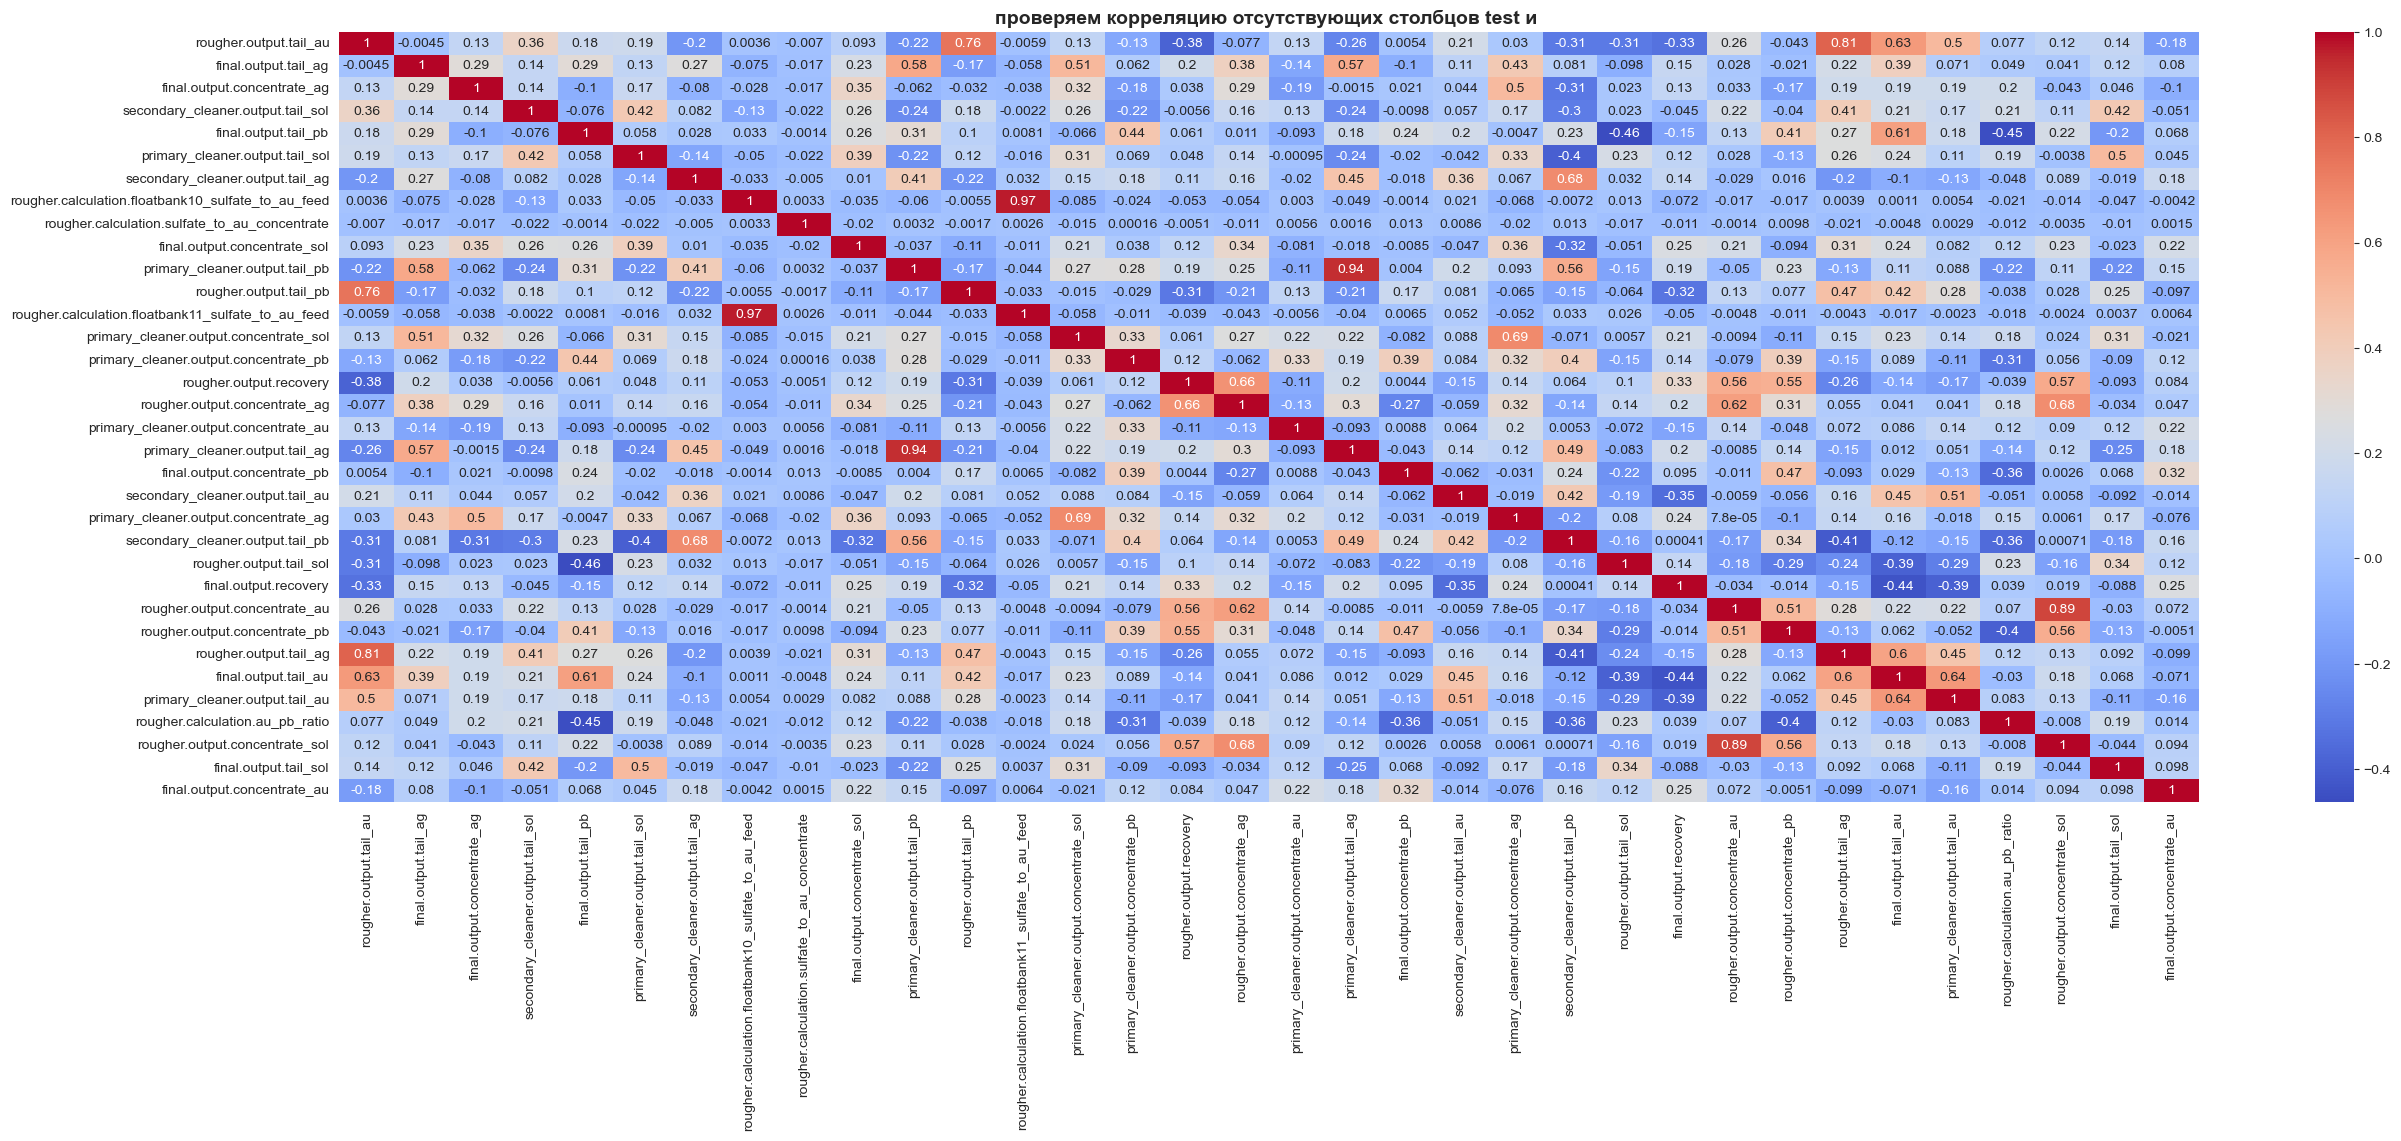

In [10]:
# проверим корреляцию отсутствующих столбцов
exam_corr = data_train.loc[:][gone_columns]
corr = exam_corr.corr()
plt.figure(figsize=(30, 10))

ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True);
ax.set_title('проверяем корреляцию отсутствующих столбцов test и ', dict(fontweight='bold', fontsize=14));
plt.show()

Корреляции в отсутствующих столбцах нет предположение выше не верное<br>
Установить причину отсутствия столбцов не удалось<br>
Обрацение к коллегам и заказчакам не внесло ястности <br>
Примим это за факт уберём из train лишние столбцы и будем работать как есть<br>
Но вначале проверим пропуски

In [11]:
# сравним данные в trein и full
data_train.describe(include='all').isin(
    data_full.loc[data_train.index].describe(include='all')).value_counts().to_frame()

0
final.output.concentrate_ag final.output.concentrate_pb final.output.concentrate_sol final.output.concentrate_au final.output.recovery final.output.tail_ag final.output.tail_pb final.output.tail_sol final.output.tail_au primary_cleaner.input.sulfate primary_cleaner.input.depressant primary_cleaner.input.feed_size primary_cleaner.input.xanthate primary_cleaner.output.concentrate_ag primary_cleaner.output.concentrate_pb primary_cleaner.output.concentrate_sol primary_cleaner.output.concentrate_au primary_cleaner.output.tail_ag primary_cleaner.output.tail_pb primary_cleaner.output.tail_sol primary_cleaner.output.tail_au primary_cleaner.state.floatbank8_a_air primary_cleaner.state.floatbank8_a_level primary_cleaner.state.floatbank8_b_air primary_cleaner.state.floatbank8_b_level primary_cleaner.state.floatbank8_c_air primary_cleaner.state.floatbank8_c_level primary_cleaner.state.floatbank8_d_air primary_cleaner.state.floatbank8_d_level rougher.calculation.sulfate_to_au_concentrate rougher.calculation.floatbank10_sulfate_to_au_feed rougher.calculation.floatbank11_sulfate_to_au_feed rougher.calculation.au_pb_ratio rougher.input.feed_ag rougher.input.feed_pb rougher.input.feed_rate rougher.input.feed_size rougher.input.feed_sol rougher.input.feed_au rougher.input.floatbank10_sulfate rougher.input.floatbank10_xanthate rougher.input.floatbank11_sulfate rougher.input.floatbank11_xanthate rougher.output.concentrate_ag rougher.output.concentrate_pb rougher.output.concentrate_sol rougher.output.concentrate_au rougher.output.recovery rougher.output.tail_ag rougher.output.tail_pb rougher.output.tail_sol rougher.output.tail_au rougher.state.floatbank10_a_air rougher.state.floatbank10_a_level rougher.state.floatbank10_b_air rougher.state.floatbank10_b_level rougher.state.floatbank10_c_air rougher.state.floatbank10_c_level rougher.state.floatbank10_d_air rougher.state.floatbank10_d_level rougher.state.floatbank10_e_air rougher.state.floatbank10_e_level rougher.state.floatbank10_f_air rougher.state.floatbank10_f_level secondary_cleaner.output.tail_ag secondary_cleaner.output.tail_pb secondary_cleaner.output.tail_sol secondary_cleaner.output.tail_au secondary_cleaner.state.floatbank2_a_air secondary_cleaner.state.floatbank2_a_level secondary_cleaner.state.floatbank2_b_air secondary_cleaner.state.floatbank2_b_level secondary_cleaner.state.floatbank3_a_air secondary_cleaner.state.floatbank3_a_level secondary_cleaner.state.floatbank3_b_air secondary_cleaner.state.floatbank3_b_level secondary_cleaner.state.floatbank4_a_air secondary_cleaner.state.floatbank4_a_level secondary_cleaner.state.floatbank4_b_air secondary_cleaner.state.floatbank4_b_level secondary_cleaner.state.floatbank5_a_air secondary_cleaner.state.floatbank5_a_level secondary_cleaner.state.floatbank5_b_air secondary_cleaner.state.floatbank5_b_level secondary_cleaner.state.floatbank6_a_air secondary_cleaner.state.floatbank6_a_level   
True                        True                        True                         True                        True                  True                 True                 True                  True                 True                          True                             True                            True                           True                                  True                                  True                                   True                                  True                           True                           True                            True                           True                                   True                                     True                                   True                                     True                                   True                                     True                                   True                                     True                                          True                                               True                            

In [12]:
exam1 = data_full.loc[data_train.index]['primary_cleaner.state.floatbank8_a_air'].describe() == data_train[
    'primary_cleaner.state.floatbank8_a_air'].describe()
exam2 = data_full.loc[data_train.index]['secondary_cleaner.state.floatbank2_b_air'].describe() == data_train[
    'secondary_cleaner.state.floatbank2_b_air'].describe()
exam3 = data_full.loc[data_train.index]['secondary_cleaner.state.floatbank2_b_level'].describe() == data_train[
    'secondary_cleaner.state.floatbank2_b_level'].describe()
exam4 = data_full.loc[data_train.index]['secondary_cleaner.state.floatbank5_a_air'].describe() == data_train[
    'secondary_cleaner.state.floatbank5_a_air'].describe()
exam_equal = pd.concat([exam1, exam2, exam3, exam4], axis=1)
display(exam_equal)

,primary_cleaner.state.floatbank8_a_air,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank5_a_air
count,True,True,True,True
mean,True,True,True,True
std,False,True,True,True
min,True,True,True,True
25%,True,True,True,False
50%,True,True,True,True
75%,True,False,True,True
max,True,True,False,True


In [13]:
exam1 = data_full.loc[data_train.index]['primary_cleaner.state.floatbank8_a_air'].sum() == data_train[
    'primary_cleaner.state.floatbank8_a_air'].sum()
exam2 = data_full.loc[data_train.index]['secondary_cleaner.state.floatbank2_b_air'].sum() == data_train[
    'secondary_cleaner.state.floatbank2_b_air'].sum()
exam3 = data_full.loc[data_train.index]['secondary_cleaner.state.floatbank2_b_level'].sum() == data_train[
    'secondary_cleaner.state.floatbank2_b_level'].sum()
exam4 = data_full.loc[data_train.index]['secondary_cleaner.state.floatbank5_a_air'].sum() == data_train[
    'secondary_cleaner.state.floatbank5_a_air'].sum()
print(exam1, exam2, exam3, exam4)

True True True True


Видим, что данные в train и full почти полностью совпадают<br>
Различия в столбцах
primary_cleaner.state.floatbank8_a_air
secondary_cleaner.state.floatbank2_b_air
secondary_cleaner.state.floatbank2_b_level
secondary_cleaner.state.floatbank5_a_air
Не значительные, можем предположить, что получились в результате округления<br>


In [14]:
# сравним данные в test и full
data_test.describe(include='all').isin(data_full.loc[data_test.index].describe(include='all')).value_counts().to_frame()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0
primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,
True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,8


Данные data_full и data_test равны
Убедились, что данные train и test принадлежат data_frame full

In [15]:
display(da)

NameError: name 'da' is not defined

In [ ]:
split = pd.DataFrame([*data_full.columns.str.split(".")], columns=['stage', 'parameter_type', 'parameter_name'])
stage = pd.Series(split['stage'].unique())
parameter_type = pd.Series(split['parameter_type'].unique())
parameter_name = pd.Series(split['parameter_name'].unique())
parameter_columns_name = pd.concat([stage, parameter_type, parameter_name], axis=1)

In [ ]:
data_train[['final.output.recovery', 'rougher.output.recovery']]


In [ ]:
parameter_columns_name

In [ ]:

exam_full = data_full.isna().sum() > 0
exam_full = pd.DataFrame(data_full.isna().sum()[exam_full]).T

plt.figure(figsize=(5, 12));
(sns.barplot(exam_full, orient='h').set_title(
    'пропуски в data_full свего {} шт., в {} столбцах'.format(exam_full.values.sum(), len(exam_full.T)),
    dict(fontweight='bold', fontsize=14)));
plt.xlim([0, 50])
plt.xticks(rotation=90);

In [ ]:
check_mae_data['rougher.output.check_recovery'] = (gold_recovery_train['rougher.output.concentrate_au'] * (
        gold_recovery_train['rougher.input.feed_au'] - gold_recovery_train['rougher.output.tail_au'])) / (
                                                          gold_recovery_train['rougher.input.feed_au'] * (
                                                          gold_recovery_train['rougher.output.concentrate_au'] -
                                                          gold_recovery_train['rougher.output.tail_au']));

## Анализ данных

## Модель

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке выполнения
- [ ]  Выполнен шаг 1: данные подготовлены
    - [ ]  Проверена формула вычисления эффективности обогащения
    - [ ]  Проанализированы признаки, недоступные в тестовой выборке
    - [ ]  Проведена предобработка данных
- [ ]  Выполнен шаг 2: данные проанализированы
    - [ ]  Исследовано изменение концентрации элементов на каждом этапе
    - [ ]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [ ]  Исследованы суммарные концентрации
- [ ]  Выполнен шаг 3: построена модель прогнозирования
    - [ ]  Написана функция для вычисления итогового *sMAPE*
    - [ ]  Обучено и проверено несколько моделей
    - [ ]  Выбрана лучшая модель, её качество проверено на тестовой выборке